In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import puzzle_finder as pf
import pandas as pd
import solver as ss
from tqdm import tqdm

In [2]:
GT_SOLUTION = np.array([
    [7, 9, 6, 1, 2, 5, 3, 4, 8],
    [4, 1, 8, 7, 3, 9, 5, 2, 6], 
    [5, 3, 2, 6, 8, 4, 7, 1, 9],
    [3, 8, 7, 2, 6, 1, 9, 5, 4],
    [9, 2, 4, 3, 5, 7, 8, 6, 1], 
    [6, 5, 1, 9, 4, 8, 2, 7, 3], 
    [2, 4, 9, 8, 7, 6, 1, 3, 5],
    [8, 6, 3, 5, 1, 2, 4, 9, 7], 
    [1, 7, 5, 4, 9, 3, 6, 8, 2]
])

GT_BOARD = np.array([
    [0, 0, 0, 0, 0, 0, 3, 0, 0],
    [4, 1, 0, 0, 3, 9, 0, 2, 6], 
    [0, 0, 0, 0, 8, 4, 0, 0, 0],
    [0, 0, 7, 0, 6, 0, 0, 5, 0],
    [0, 2, 0, 3, 0, 7, 0, 6, 0], 
    [0, 5, 0, 0, 4, 0, 2, 0, 0], 
    [0, 0, 0, 8, 7, 0, 0, 0, 0],
    [8, 6, 0, 5, 1, 0, 0, 9, 7], 
    [0, 0, 5, 0, 0, 0, 0, 0, 0]
])


In [3]:
solutions = []
boards = []

In [4]:
# Iterate through the frames of the video, attempting to solve the puzzle found on each frame. 
# Save all boards and solutions for accuracy analysis

vid_cap = cv2.VideoCapture('../sudoku_vids/IMG_2511.MOV')
while True:
    ret, frame = vid_cap.read()
    if not ret:
        break
    puzzle = pf.find_puzzle(frame)
    nums_only = pf.isolate_nums(puzzle)
    squares = pf.split_squares(nums_only)
    number_mask = pf.mask_numbers(squares)
    pf.center_squares(squares, number_mask)
    board = pf.apply_model(squares, number_mask)
    boards.append(board.copy())
    board, iters = ss.solve_sudoku(board)
    solutions.append(board)
    
vid_cap.release()
cv2.destroyAllWindows()

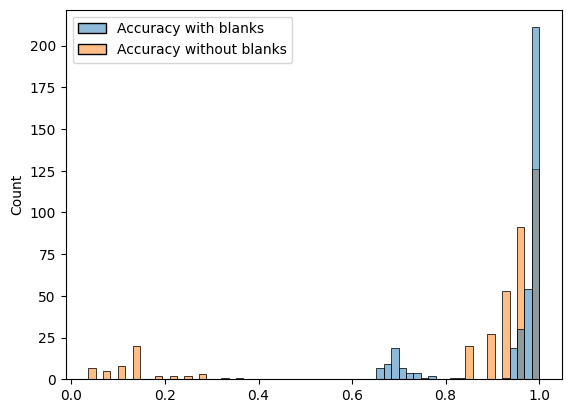

The correct board was detected 124 times, 33.60 percent of the total frames
The correct number was placed in a non-blank cell 84.60 percent of the time
The correct value (number or blank) was placed 94.39 percent of the time
A blank cell was correctly placed 99.56 percent of the time


In [9]:
accuracy_with_blanks = []
accuracy_without_blanks = []
accuracy_only_blanks = []
GT_NUM_MASK = GT_BOARD != 0

for board in boards:
    accuracy_with_blanks.append(np.sum(board == GT_BOARD)/81)
    accuracy_without_blanks.append(np.sum((board == GT_BOARD) & GT_NUM_MASK)/np.sum(GT_NUM_MASK))
    accuracy_only_blanks.append(np.sum((board == GT_BOARD) & ~GT_NUM_MASK)/np.sum(~GT_NUM_MASK))

accuracy_without_blanks = np.array(accuracy_without_blanks)
accuracy_with_blanks = np.array(accuracy_with_blanks)
accuracy_only_blanks = np.array(accuracy_only_blanks)
accuracy_df = pd.DataFrame(np.array([accuracy_with_blanks, accuracy_without_blanks]).T, columns = ['Accuracy with blanks', 'Accuracy without blanks'])
sns.histplot(data = accuracy_df)
plt.show()

print(f'The correct board was detected {sum(accuracy_with_blanks == 1.)} times, {100 * sum(accuracy_with_blanks == 1.)/len(accuracy_with_blanks):.2f} percent of the total frames')
print(f'The correct number was placed in a non-blank cell {100 * accuracy_without_blanks.mean():.2f} percent of the time')
print(f'The correct value (number or blank) was placed {100 * accuracy_with_blanks.mean():.2f} percent of the time')
print(f'A blank cell was correctly placed {100 * accuracy_only_blanks.mean():.2f} percent of the time')

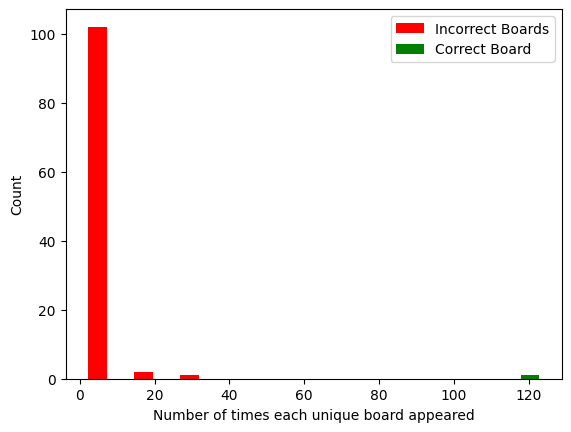

The vast majority of incorrect boards only appear once
The most frequent incorrect board appeared 31 times


In [6]:
incorrect_boards = np.array([b for b in boards if not np.array_equal(b, GT_BOARD)])
correct_board_count = len(boards) - len(incorrect_boards)
unique, counts = np.unique(incorrect_boards, axis = 0, return_counts = True)

plt.hist([counts, [correct_board_count]], color = ['Red', 'Green'], label = ['Incorrect Boards', 'Correct Board'], bins = 10)
plt.xlabel('Number of times each unique board appeared')
plt.ylabel('Count')
plt.legend()
plt.show()

print(f'The vast majority of incorrect boards only appear once')
print(f'The most frequent incorrect board appeared {max(counts)} times')

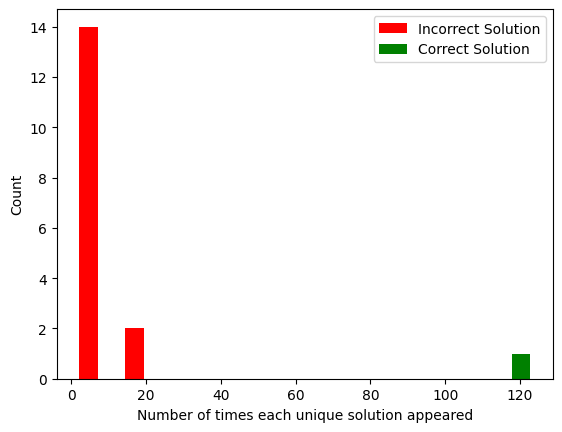

The most frequent incorrect board appeared 19 times
When a solution is found, 66.67 percent of the time it is correct


In [7]:
valid_solutions = [s for s in solutions if type(s) != str]
incorrect_solutions = np.array([s for s in valid_solutions if not np.array_equal(s, GT_SOLUTION)])
correct_board_count = len(valid_solutions) - len(incorrect_solutions)
unique, counts = np.unique(incorrect_solutions, axis = 0, return_counts = True)

plt.hist([counts, [correct_board_count]], color = ['Red', 'Green'], label = ['Incorrect Solution', 'Correct Solution'], bins = 10)
plt.xlabel('Number of times each unique solution appeared')
plt.ylabel('Count')
plt.legend()
plt.show()

print(f'The most frequent incorrect board appeared {max(counts)} times')
print(f'When a solution is found, {100 * correct_board_count/len(valid_solutions):.2f} percent of the time it is correct')